In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

#### Per traininare highZ è sufficiente modificare
    samples_version : DNN_v7/lowZ/train--> DNN_v7/highZ/train
    model_version: 0107/lowZ/v* --> 0107/highZ/v*

In [2]:
config = {
    "base_dir":        "/eos/home-b/bpinolin/ML_output/",
    "plot_config":     "VBSOS",
    "cut":             "sr",
    "samples_version": "DNN_v7/lowZ/train",   
    "model_version":   "0107/lowZ/v0",   #cambiare versione modello
    "model_tag":       "3l_50n_dropout01_l2_batchnorm_relu",
    "cols": [
             'detajj',
             'ptll',
             'detall',        
             'jetpt1', 
             'jetpt2', 
             'met',
             'dphill',
             'dphijj',
             'Mll',
             'dR_jl1',
             'dR_jl2',
             'mjj',
             'Zepp1',
             'Zepp2',
             'qgl_forward',
             'qgl_central',
             'mtw1',
             'mtw2'
            ],
    "test_size": 0.2,
    "val_size": 0.0,
    "optimizer": "adam",
    "batch_size": 128
}

In [3]:
import os

config_base_dir = os.path.join(config["base_dir"], config["plot_config"])
# create the model directory
model_dir   = os.path.join(config_base_dir, config["cut"] , "models",  config["model_version"])
os.makedirs(model_dir, exist_ok=True)
plot_dir = os.path.join(model_dir, "plots")
os.makedirs(plot_dir, exist_ok=True)
# load numpy
samples_dir = os.path.join(config_base_dir, config["cut"] , "samples", config["samples_version"])
file_sig_bal = os.path.join(samples_dir, "for_training/signal_balanced.pkl")
file_bkg_bal = os.path.join(samples_dir, "for_training/background_balanced.pkl")

In [4]:
import pickle
signal = pickle.load(open(file_sig_bal, "rb"))
bkg = pickle.load(open(file_bkg_bal, "rb"))

In [5]:
bkg = bkg.dropna()
signal = signal.dropna()

## log mjj and jetpt

## REWEIGHT

In [6]:
signal["weight_"] = (signal['mjj']<2000)*signal["weight_"]+(signal['mjj']>=2000)*(signal['mjj']/2000)*signal["weight_"]
bkg["weight_"] = (bkg['mjj']<2000)*bkg["weight_"]+(bkg['mjj']>=2000)*(bkg['mjj']/2000)*bkg["weight_"]

## Samples preparation for NN

In [7]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [8]:
X_sig = signal[config["cols"]].values
X_bkg = bkg[config["cols"]].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight_norm"]).values
W_bkg = (bkg["weight_norm"]).values
Wnn_sig = (signal["weight_"]).values
Wnn_bkg = (bkg["weight_"]).values

X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])
Wnn = np.hstack([Wnn_sig, Wnn_bkg])

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open(f"{model_dir}/scaler_model.pkl", "wb"))

In [10]:
top = scaler.transform(bkg[bkg.sample_name=="top"][config["cols"]].values)

##  Balancing

In [11]:
X_train, X_test, y_train, y_test, W_train, W_test , Wnn_train, Wnn_test = train_test_split(X_scaled, Y,  W, Wnn, test_size=config["test_size"], random_state=42, stratify=Y)

print("Training   dataset: ", X_train.shape)
print("Test + Val dataset: ", X_test.shape)

Training   dataset:  (61948, 18)
Test + Val dataset:  (15488, 18)


## Keras model

In [12]:
%load_ext autoreload

In [13]:
%autoreload 2

In [14]:
import dnn_models
import tensorflow as tf

print(config["model_tag"])
model = dnn_models.get_model(config["model_tag"], X_train.shape[1])

model.compile(optimizer=config["optimizer"],
            loss='binary_crossentropy',
            metrics=['accuracy'])

model.summary()

Using TensorFlow backend.
W0107 21:42:48.194874 140626442491712 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0107 21:42:48.226059 140626442491712 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0107 21:42:48.231576 140626442491712 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



3l_50n_dropout01_l2_batchnorm_relu
>>> Creating model...


W0107 21:42:48.587991 140626442491712 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0107 21:42:48.635502 140626442491712 deprecation.py:506] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0107 21:42:49.099170 140626442491712 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please u

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                950       
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_2 (Batch (None, 50)                200       
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
__________

In [15]:
from imblearn.keras import balanced_batch_generator
from imblearn.over_sampling import RandomOverSampler

training_generator,   steps_per_epoch_train = balanced_batch_generator(X_train, y_train, W_train, batch_size=config["batch_size"], sampler=RandomOverSampler())
validation_generator, steps_per_epoch_val   = balanced_batch_generator(X_test,  y_test,  W_test,   batch_size=config["batch_size"], sampler=RandomOverSampler())

In [16]:
import dnn_plot_loss

data = {
    "X_train": X_train, 
    "X_val" : X_test, 
    "y_train": y_train,
    "y_val" : y_test, 
    "W_train": W_train,
    "W_val": W_test, 
    "Wnn_train": Wnn_train,
    "Wnn_val": Wnn_test, 
}

plot_losses = dnn_plot_loss.PlotLosses(model, data, dnncut=0.9, batch_mode=False)

### Training

In [17]:
import time
start_time = time.time()

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', 
                            min_delta=0.0002, patience=30, verbose=0, mode='auto', 
                            baseline=None, restore_best_weights=True)

### Cyclic learning rate

In [19]:
training_iterations_in_epoch = ((len(signal)+len(bkg))/config["batch_size"])
print("Step size ottimale per il cyclic learning tra ", int(2*training_iterations_in_epoch), " e ", int(8*training_iterations_in_epoch))

Step size ottimale per il cyclic learning tra  1209  e  4839


https://www.pyimagesearch.com/2019/07/29/cyclical-learning-rates-with-keras-and-deep-learning/#:~:text=learning%20rate%20range.-,What%20are%20cyclical%20learning%20rates%3F,you%20simply%20need%20a%20callback.

In [20]:
lr_base = 0.0003
lr_max = 0.005
ss = 4800
# Ti consiglio in questo caso di usare gli step_size consigliati dall'algoritmo (quelli scritti sopra) per evitare l'OT e avere delle loss belline
config["step_size"] = ss
config["lr_max"] = lr_max
config["lr_base"] = lr_base

import cyclical_learning_rate
cycl = cyclical_learning_rate.CyclicLR(base_lr=lr_base,
                max_lr=lr_max,
                step_size=ss,
                mode="triangular")

### Training

In [21]:
config["epochs"] = 500

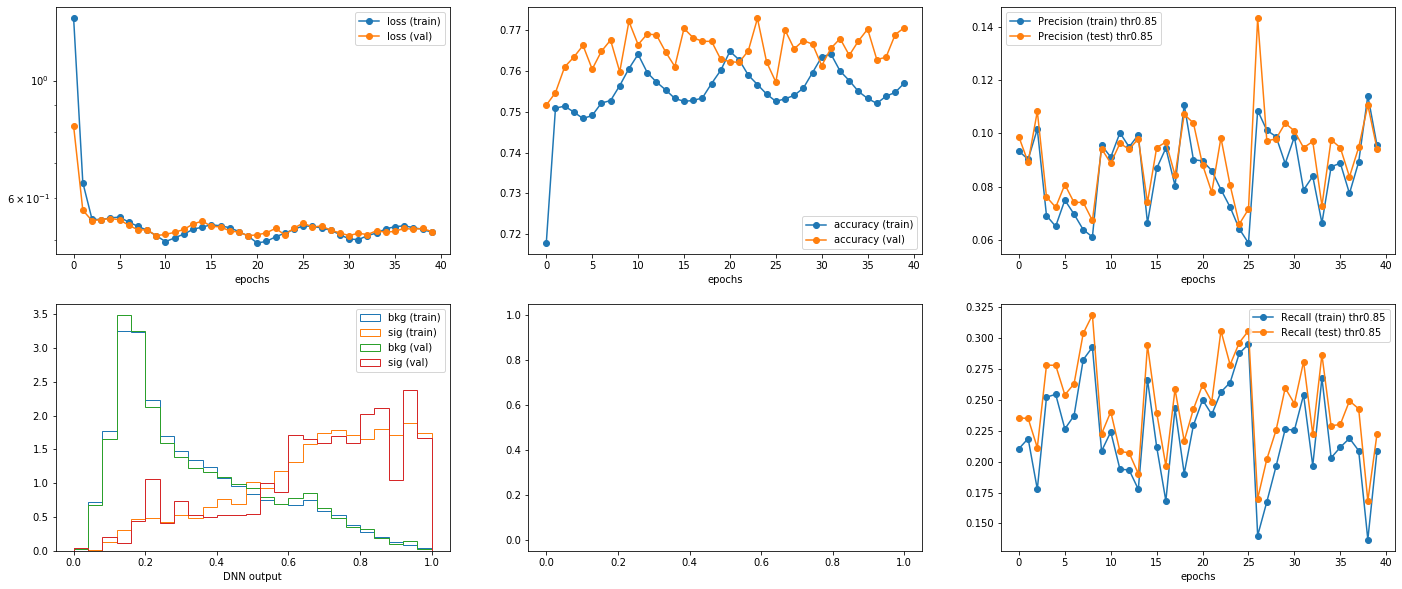

In [22]:
history = model.fit_generator(
            training_generator, 
            epochs=config["epochs"],
            steps_per_epoch  = steps_per_epoch_train, 
            validation_data  = validation_generator, 
            validation_steps = steps_per_epoch_val,
            callbacks=[early_stopping, plot_losses, cycl]
            )

config["train_time"] = time.time() - start_time

In [30]:
config["train_time"]

340.68045115470886

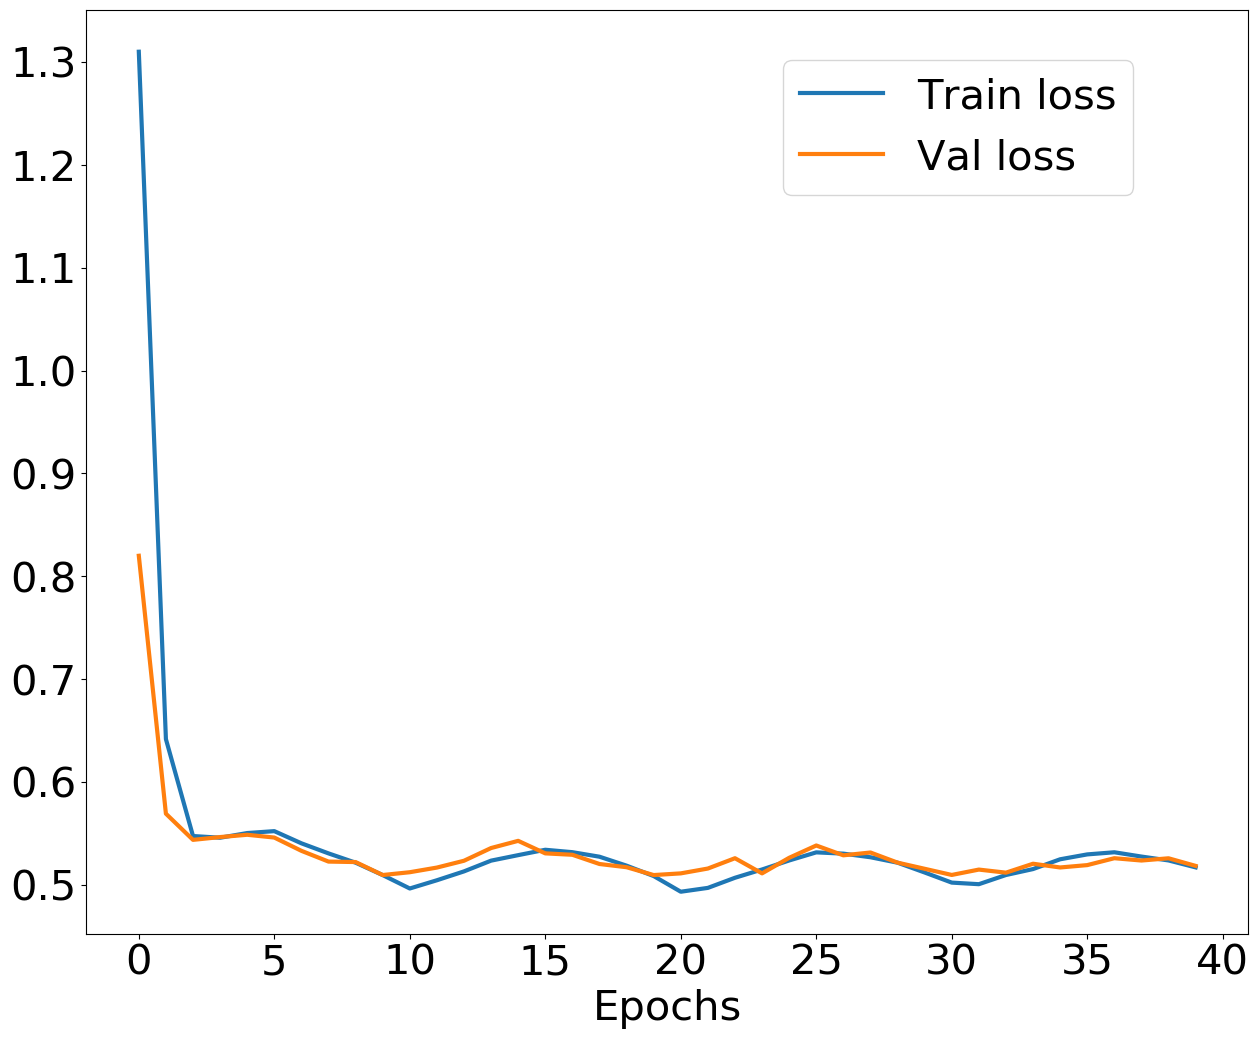

In [31]:
plt.style.use("default")
fig = plt.figure(figsize=(15,12), dpi=100)
plt.plot(history.history["loss"], lw = 3, label="Train loss")
plt.plot(history.history["val_loss"], lw = 3, label="Val loss")
plt.legend(loc=(0.6,0.8), fontsize=30)
plt.xlabel("Epochs", fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.savefig(os.path.join(model_dir, "plots/loss.pdf"))
plt.savefig(os.path.join(model_dir, "plots/loss.png"))
plt.show()

In [25]:
## SAVE THE MODEL, ITS METADATA AND TRAINING INFORMATIONS

# dump the variables list
import yaml
varfile = os.path.join(model_dir, "variables.yml")
if os.path.isfile(varfile):
    print("ACHTUNG! variables file already existing: old file renamed with '_old'")
    os.rename(varfile, varfile[:-4] + "_old.yml")
with open(varfile, "w") as out_var_file:
    out_var_file.write(yaml.dump(config["cols"]))

In [26]:
# dump the config
config["a__model_dir"] = model_dir
model_config_file = os.path.join(model_dir, "model_config.yml")
if os.path.isfile(model_config_file):
    print("ACHTUNG! model_config_file file already existing: old file renamed with '_old'")
    os.rename(model_config_file, model_config_file[:-4] + "_old.yml")
with open(model_config_file, "w") as out_var_file:
    out_var_file.write(yaml.dump(config))  

In [27]:
# save figure with training summary
plot_losses.save_figure( os.path.join(model_dir, "model_train.png") )

In [28]:
# save keras model
model.save(os.path.join(model_dir, "model.h5") )

In [29]:
## Export:
## * keras model to tensorflow model
## * tf metadata
## * scaler

args = {
    "dir": model_dir,
    "input": "model.h5",
    "output": "model.pb",
    "tf_metadata": "tf_metadata.txt",
    "input_scaler": "scaler_model.pkl",
    "output_scaler": "scaler.txt",
}


from keras import backend as K
# This line must be executed before loading Keras model.
K.set_learning_phase(0)

from keras.models import load_model
model = load_model(os.path.join(args["dir"], args["input"]))

from keras import backend as K

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph


frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])

# Save to ./model/tf_model.pb
tf.train.write_graph(frozen_graph, args["dir"], args["output"], as_text=False)

## save tensorflow metadata
with open(os.path.join(args["dir"], args["tf_metadata"]), "w") as f:
    f.write(str(model.inputs[0].name) + " " + str(model.outputs[0].name) + "\n")


## Export 
## * tf tensor input name and output name
## * scaler mean_ and scale_ (where scale_ = np.sqrt(var_)) for each variable
##
import os
import pickle

import yaml
yaml_vars = yaml.safe_load(open(os.path.join(args["dir"], "variables.yml"), "r"))

scaler = pickle.load(open(os.path.join(args["dir"], args["input_scaler"]), 'rb'))
with open(os.path.join(args["dir"], args["output_scaler"]), "w") as f:
    for var, mean, scale in zip(yaml_vars, scaler.mean_, scaler.scale_):
        f.write(var + " " + str(mean) + " " + str(scale) + "\n")

W0107 21:48:38.516351 140626442491712 deprecation.py:323] From <ipython-input-29-1725bfe571ff>:52: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
W0107 21:48:38.517618 140626442491712 deprecation.py:323] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/tensorflow/python/framework/graph_util_impl.py:270: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


## ROC Curves

print("If the KS statistic is small (the p-value is high), then we cannot reject the hypothesis that the distributions of the two samples are the same.")
print("The KS value for the signal is ", round(ks_sig[0],2))
print("The KS p-value for the signal is ", round(ks_sig[1],2), ". It must be > 0.05")
print("The KS value for the background is ", round(ks_bkg[0],2))
print("The KS p-value for the background is ", round(ks_bkg[1],2), ". It must be > 0.05")

### ROC with sklearn